README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Epoch 1/3 | Train Loss: 0.3827 | Val Loss: 0.3080 | Val Accuracy: 0.8642
Epoch 2/3 | Train Loss: 0.2652 | Val Loss: 0.3194 | Val Accuracy: 0.8634
Epoch 3/3 | Train Loss: 0.1942 | Val Loss: 0.3001 | Val Accuracy: 0.8764


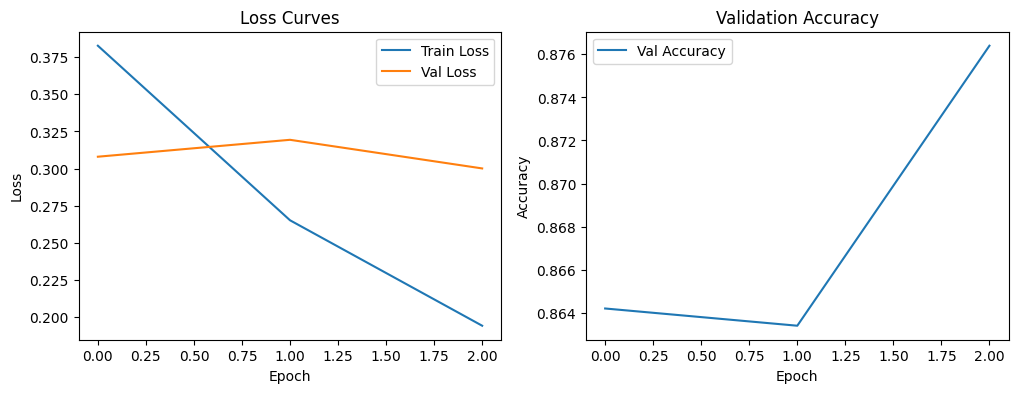

Test Accuracy: 0.8736
Precision: 0.8722 | Recall: 0.8754 | F1-Score: 0.8738


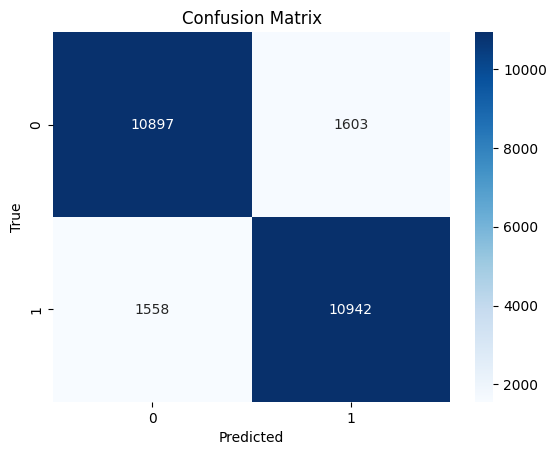

Sample Review: 'This movie was absolutely fantastic!' -> Sentiment: Positive


In [46]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel
from datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_imdb_data():
    dataset = load_dataset("imdb")
    train_data = dataset["train"]
    test_data = dataset["test"]

    train_size = int(0.8 * len(train_data))
    val_size = len(train_data) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        train_data, [train_size, val_size]
    )

    return train_dataset, val_dataset, test_data

class IMDBDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_len=128):
        self.reviews = [item["text"] for item in dataset]
        self.labels = [item["label"] for item in dataset]  # 0 = negative, 1 = positive
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        label = self.labels[idx]

        # Tokenize the review
        encoding = self.tokenizer(
            review,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),  # Remove batch dimension
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

class TransformerClassifier(nn.Module):
    def __init__(self, pretrained_model_name="distilbert-base-uncased"):
        super(TransformerClassifier, self).__init__()

        self.bert = DistilBertModel.from_pretrained(pretrained_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask):

        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)
        return logits

class SimpleTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=512, n_heads=8, n_layers=1, max_len=128):
        super(SimpleTransformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = self.create_pos_encoding(max_len, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, n_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, n_layers)
        self.fc = nn.Linear(d_model, 2)

    def create_pos_encoding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.embedding(x) + self.pos_encoding[:, :x.size(1), :].to(x.device)
        x = self.transformer(x)
        x = x.mean(dim=1)  # Pooling over sequence
        return self.fc(x)

def train_model(model, train_loader, val_loader, epochs=5, lr=1e-5):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []
    val_accuracies = []

    for epoch in range(epochs):
        # Training Phase
        model.train()
        total_train_loss = 0
        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation Phase
        model.eval()
        total_val_loss = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)

                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")

    return train_losses, val_losses, val_accuracies

def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="binary")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1-Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def predict_sentiment(model, tokenizer, text, max_len=128):
    model.eval()
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_len,
        return_tensors="pt"
    )
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        pred = torch.argmax(outputs, dim=1).item()

    return "Positive" if pred == 1 else "Negative"

if __name__ == "__main__":
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    train_dataset, val_dataset, test_data = load_imdb_data()

    train_dataset = IMDBDataset(train_dataset, tokenizer)
    val_dataset = IMDBDataset(val_dataset, tokenizer)
    test_dataset = IMDBDataset(test_data, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    test_loader = DataLoader(test_dataset, batch_size=32)

    model = TransformerClassifier().to(device)
    train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, epochs=3)

    # Plot training results
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curves")

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Validation Accuracy")
    plt.show()

    evaluate_model(model, test_loader)

    sample_review = "This movie was absolutely fantastic!"
    sentiment = predict_sentiment(model, tokenizer, sample_review)
    print(f"Sample Review: '{sample_review}' -> Sentiment: {sentiment}")